In [1]:
import pandas as pd
import numpy as np
import time
from pycaret.classification import *

In [2]:
def check_class_ratio(dataset):
    class_ratio = round(np.mean(dataset.classes), 2)
    return class_ratio

def random_split_stay(df, train_ratio, Threshold, n_trial):
    data = df.copy()
    
    search_time = time.time()
    
    for T in range(n_trial):
        array = data.subject_id.unique()
        
        # seed = np.random.randint(0, 10000, 1)
        seed = 3582
        np.random.seed(seed) 
        np.random.shuffle(array)


        split_point = int(train_ratio * len(array))
        stay_for_train, stay_for_test = np.split(array, [split_point])

        

        condition_train = data.subject_id.isin(stay_for_train)
        holdout_train = data[condition_train]

        condition_test = data.subject_id.isin(stay_for_test)
        holdout_test = data[condition_test]
        
        # holdout_test = holdout_test.sort_values(by=['subject_id',  'stay_id', 'Time_since_ICU_admission']) 
        # holdout_train = holdout_train.sort_values(by=['subject_id',  'stay_id', 'Time_since_ICU_admission']) 

        train_class_ratio  = check_class_ratio(holdout_train)
        test_class_ratio  = check_class_ratio(holdout_test)
                
            
        if (train_class_ratio - test_class_ratio) >= Threshold:
            
            break  # 클래스 비율이 모두 threshold 이상일 경우 반복문 종료
        
        if T % 100 == 0:
            print('Trial: ', T)
            
        if T % 10000 == 0:
        
            Threshold = Threshold + 0.05
            print('Threshold 조정 + 0.05, 현재 한계값: {}'.format(Threshold))
        
        if T == 9999:
            print('최대 Trial 달성, 분할 불가')
        
    train = holdout_train.copy()
    test = holdout_test.copy()
    search_time_end = time.time()
    
    trn_class1 = train.classes.value_counts()[0]
    trn_class2 = train.classes.value_counts()[1]
    
    tes_class1 = test.classes.value_counts()[0]
    tes_class2 = test.classes.value_counts()[1]

    
    
    print('train set : test set = {} : {}'.format(train_ratio, 1-train_ratio))
    print('Train set class: ', train.classes.value_counts().sort_index())
    print('Test set class: ', test.classes.value_counts().sort_index())
    print('-'*20)
    print('Train class ratio: {}:{}'.format((trn_class1)/(trn_class1+trn_class2), (trn_class2)/(trn_class1+trn_class2)))
    print('Test class ratio: {}:{}'.format((tes_class1)/(tes_class1+tes_class2), (tes_class2)/(tes_class1+tes_class2)))
    print('-'*20)
    print('Number of trainset patient:', len(train.subject_id.unique()))
    print('Number of testset patient:', len(test.subject_id.unique()))
    print('Number of trainset stay:', len(train.stay_id.unique()))
    print('Number of testset stay:', len(test.stay_id.unique()))
    print('-'*20)
    print('Split seed: ',seed)
    print('train ratio:', train_ratio)
    print('Threshold:', Threshold)
    print('-'*20)
    print('총 소요 시간(초):{}'.format(search_time_end - search_time))
    print('시도한 trial 수: ', T)
    
    return train, test, stay_for_train, stay_for_test

In [3]:
dataset = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/MIMIC_pipeline/Case Labeling/mimic_df.csv.gz', index_col = 0, compression='gzip')

In [4]:
embset = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/MIMIC_pipeline/supervised_contrastive_learning/embedding_data.csv.gz', index_col = 0, compression='gzip')

In [5]:
total_dataset = pd.concat([dataset.reset_index(drop=True), embset.drop(['subject_id', 'stay_id', 'hadm_id', '43'], axis = 1).reset_index(drop=True)], axis = 1)

In [15]:
def filter_classes_with_condition(df):
    filtered_df = df.copy()
    result_df = filtered_df[filtered_df['classes'] == 2]
    result_df2 = filtered_df[filtered_df['classes'] == 3]
    df = pd.concat([result_df, result_df2])
    df['classes'] = df['classes'].map({2:0, 3:1})
    return df

In [7]:
recovery_situation = {0, 1, 2, 3}
deterioration_situation = {0, 1, 3}

    
recover_state = total_dataset[total_dataset['classes'].isin(recovery_situation)].groupby('stay_id')['classes'].nunique()
recover_state = recover_state[recover_state == len(recovery_situation)].index

recover_set = total_dataset[total_dataset['stay_id'].isin(recover_state)]

deterioration_state = total_dataset[total_dataset['classes'].isin(deterioration_situation)].groupby('stay_id')['classes'].nunique()
deterioration_state = deterioration_state[deterioration_state == len(deterioration_situation)].index

deterioration_set = total_dataset[total_dataset['stay_id'].isin(deterioration_state)]

def filter_classes_with_condition(df):
    filtered_df = df[df['classes'].isin([0, 1, 3])]
    return filtered_df

deterioration_set = filter_classes_with_condition(deterioration_set)

deterioration_grouped = deterioration_set.groupby('stay_id')

# 조건에 맞는 stay_id를 찾는 함수
def deterioration_filter_stay_ids(group):
    # 처음 3개 관측치의 Annotation이 모두 'no_circ'인지 확인
    if all(group.head(3)['Annotation'] == 'no_circ'):
        # 마지막 관측치의 10개가 classes가 3인지 확인
        if all(group.tail(10)['classes'] == 3):
            return True
    return False

# 조건을 만족하는 stay_id 필터링
valid_stay_ids = [name for name, group in deterioration_grouped if deterioration_filter_stay_ids(group)]
deterioration_df = deterioration_set[deterioration_set.stay_id.isin(valid_stay_ids)].copy()

recover_grouped = recover_set.groupby('stay_id')

def recovery_filter_stay_ids(group):
    # 처음 3개 관측치의 Annotation이 모두 'no_circ'인 경우만 고려
    if all(group.head(3)['Annotation'] == 'no_circ'):
        # 'classes'가 2인 마지막 관측치 찾기
        last_class_2_index = group[group['classes'] == 2].index.max()
        if pd.notna(last_class_2_index):
            # 해당 인덱스까지의 데이터 반환
            return group.loc[:last_class_2_index]
    return pd.DataFrame()

# 조건을 만족하는 데이터 필터링
recovery_df = pd.concat([recovery_filter_stay_ids(group) for _, group in recover_grouped])

In [10]:
total_dataset = pd.concat([recovery_df, deterioration_df])

In [16]:
mimic_train_ori, mimic_valid_ori, trn_patient, val_patient = random_split_stay(total_dataset, 0.7, Threshold=0.05, n_trial=1) 
mimic_train_ori_sampling = filter_classes_with_condition(mimic_train_ori)
mimic_valid_ori_sampling = filter_classes_with_condition(mimic_valid_ori)

train set : test set = 0.7 : 0.30000000000000004
Train set class:  0    30186
1     6755
2     2015
3    36032
Name: classes, dtype: int64
Test set class:  0    16072
1     2860
2      815
3    15979
Name: classes, dtype: int64
--------------------
Train class ratio: 0.8171408462142336:0.1828591537857665
Test class ratio: 0.8489330234523558:0.1510669765476442
--------------------
Number of trainset patient: 908
Number of testset patient: 390
Number of trainset stay: 923
Number of testset stay: 398
--------------------
Split seed:  3582
train ratio: 0.7
Threshold: 0.05
--------------------
총 소요 시간(초):0.09093284606933594
시도한 trial 수:  0


In [28]:
# original space, circulatory prediction

input_space_clf_setting = setup(data = mimic_train_ori_sampling.drop(['Unnamed: 0', 'subject_id', 'stay_id', 'hadm_id','Annotation','CIRC_next_12h'], axis = 1), target = 'classes',
                                test_data = mimic_valid_ori_sampling.drop(['Unnamed: 0', 'subject_id', 'stay_id', 'hadm_id','Annotation','CIRC_next_12h'], axis = 1), normalize=True,
                                index=False, session_id = 123)

,Description,Value
0,Session id,123
1,Target,classes
2,Target type,Binary
3,Original data shape,"(61387, 255)"
4,Transformed data shape,"(61387, 255)"
5,Transformed train set shape,"(43401, 255)"
6,Transformed test set shape,"(17986, 255)"
7,Numeric features,254
8,Preprocess,True
9,Imputation type,simple


In [67]:
import gc
gc.collect()

2076

In [29]:
from sklearn.metrics import average_precision_score
add_metric('AUPRC_0', 'AUPRC_0', average_precision_score, target = 'pred_proba', pos_label = 0)
add_metric('AUPRC_1', 'AUPRC_1', average_precision_score, target = 'pred_proba', pos_label = 1)

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
# create a custom function
def Recall_pos_0(y_true, y_pred):
    return recall_score(y_true
                        , y_pred
                        , pos_label=0
                        , zero_division=1)
    
def Precision_pos_0(y_true, y_pred):
    return precision_score(y_true
                        , y_pred
                        , pos_label=0
                        , zero_division=1)
    
# add metric to PyCaret
add_metric('recall_0', 'recall_0', Recall_pos_0, greater_is_better = True)
# add metric to PyCaret
add_metric('precision_0', 'precision_0', Precision_pos_0, greater_is_better = True)

Name                                                       precision_0
Display Name                                               precision_0
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                    make_scorer(Precision_pos_0)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: precision_0, dtype: object

In [21]:
lightgbm = create_model('lightgbm', cross_validation=False, learning_rate=0.1)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC_0,AUPRC_1,recall_0,precision_0
Test,0.9716,0.9779,0.9893,0.9811,0.9852,0.6417,0.6449,0.0232,0.9989,0.5988,0.7262


In [22]:
#FICS: Fairness-Incorporated Composite Score
def FICS(auprc, f1score, w1, w2):
    fics = auprc*w1 + f1score*w2
    print(fics)

In [23]:
FICS(0.0232, 0.9859, 18.7, 1)

1.4788000000000001


In [24]:
xgboost = create_model('xgboost', cross_validation=False, learning_rate=0.1)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC_0,AUPRC_1,recall_0,precision_0
Test,0.9718,0.9785,0.9904,0.9802,0.9853,0.6361,0.6414,0.0232,0.9989,0.5791,0.7421


In [14]:
FICS(0.0154, 0.9862, 32, 1)

1.479


In [25]:
lr = create_model('lr', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC_0,AUPRC_1,recall_0,precision_0
Test,0.9549,0.8674,0.9983,0.9564,0.9769,0.0691,0.1364,0.0246,0.9919,0.0405,0.5238


In [16]:
FICS(0.0161, 0.9850, 32, 1)

1.5002


In [30]:
svm = create_model('svm', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC_0,AUPRC_1,recall_0,precision_0
Test,0.9734,0.8061,0.9901,0.9822,0.9861,0.6659,0.6690,0.0349,0.9819,0.6221,0.7489


In [18]:
FICS(0.0283	, 0.9827, 32, 1)

1.8883


In [27]:
nb = create_model('nb', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC_0,AUPRC_1,recall_0,precision_0
Test,0.4124,0.8246,0.3869,0.9937,0.5570,0.0471,0.1443,0.0254,0.9882,0.9485,0.0684


In [20]:
FICS(0.0168	, 0.6356, 32, 1)

1.1732


In [39]:
test_data = mimic_valid_ori_sampling.copy().reset_index(drop=True)
idx = test_data[test_data['classes']==1].index
test_data['Annotation'].loc[idx] = 'no_circ'

In [57]:
test_data[test_data['stay_id']==test_data.stay_id.unique()[3]][['Time_since_ICU_admission','Annotation', 'CIRC_next_12h', 'classes']].sort_values(by='Time_since_ICU_admission')

,Time_since_ICU_admission,Annotation,CIRC_next_12h,classes
3542,3,no_circ,1.0,1
3543,4,no_circ,1.0,1
3544,5,no_circ,1.0,1
3545,6,no_circ,1.0,1
3546,7,no_circ,1.0,1
3547,8,no_circ,1.0,1
3548,9,no_circ,1.0,1
3549,10,no_circ,1.0,1
3550,11,no_circ,1.0,1
3551,12,no_circ,1.0,1


In [58]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import numpy as np
from tqdm import tqdm

def filter_numeric_elements(lst):
    return [x for x in lst if isinstance(x, (int, float))]

def calculate_cap_recall(df, stid):
    # 데이터프레임 복사본 생성
    df_stid = df[df['stay_id'] == stid].copy()

    # 연속적인 circ 이벤트 처리
    df_stid['circ_event'] = (df_stid['Annotation'] == 'circ') & (df_stid['Annotation'].shift(1) != 'circ')

    # circ 이벤트 시작 시점 찾기
    circ_start_times = df_stid[df_stid['circ_event']]['Time_since_ICU_admission'].tolist()
    captured_events = 0
    drop_event = 0
    for start_time in circ_start_times:
        if start_time == df_stid['Time_since_ICU_admission'].values[0]:
            drop_event += 1
        else:
            window_start = start_time - 12
            previous_times = df_stid[(df_stid['Time_since_ICU_admission'] >= window_start) & (df_stid['Time_since_ICU_admission'] < start_time)]

            # 이전 시간 데이터가 없는 경우도 평가에서 제외
            if previous_times.empty:
                drop_event += 1
            elif any(previous_times['prediction_label'] == 1):
                captured_events += 1

    total_events = len(circ_start_times) - drop_event
    if total_events > 0:
        return captured_events / total_events
    else:
        return f'no event in stay id {stid}'  # 또는 적절한 값 반환
    
    
def calculate_precision(df, stid):
    # 특정 stay_id에 대한 데이터만 필터링
    df_stid = df[df['stay_id'] == stid].copy()

    df_stid['circ_event'] = (df_stid['Annotation'] == 'circ') & (df_stid['Annotation'].shift(1) != 'circ')
    circ_start_times = df_stid[df_stid['circ_event']]['Time_since_ICU_admission'].tolist()
    
    # True Alarms와 Total Alarms 초기화
    true_alarms = 0
    total_alarms = 0
    
    # 데이터 프레임의 첫 관측치 시간 가져오기
    first_observation_time = df_stid['Time_since_ICU_admission'].min()
    
    for start_time in circ_start_times:
        # 첫 관측치에서 circ가 시작된 경우, 이를 precision 계산에서 제외
        if start_time == first_observation_time:
            continue
        
        # 이벤트 발생 전 12시간 동안의 예측된 알람 찾기
        window_start = max(start_time - 12, first_observation_time)  # window 시작이 첫 관측치 시간보다 이전이면 첫 관측치 시간으로 설정
        window_end = start_time
        alarms_in_window = df_stid[(df_stid['Time_since_ICU_admission'] >= window_start) & 
                                   (df_stid['Time_since_ICU_admission'] < window_end) & 
                                   (df_stid['prediction_label'] == 1)]
        
        # 전체 알람 (Total Alarms) 계산
        total_alarms += len(alarms_in_window)

        # 진정한 알람 (True Alarms) 계산
        if df_stid.loc[df_stid['Time_since_ICU_admission'] == start_time, 'CIRC_next_12h'].any():
            true_alarms += len(alarms_in_window)

    # Precision 계산
    precision = true_alarms / total_alarms if total_alarms > 0 else 0  # 알람이 전혀 없으면 precision은 0으로 설정
    
    return precision


def make_evaluation(model):

    pred_df = predict_model(model, raw_score=True, data = test_data)

    evaluation = test_data[['subject_id', 'stay_id', 'Time_since_ICU_admission', 'Annotation','classes', 'CIRC_next_12h']].copy().sort_values('Time_since_ICU_admission')
    evaluation['prediction_label'] = pred_df['prediction_label'].values

    case2_recall_precision = evaluation[(evaluation['CIRC_next_12h']==0) | (evaluation['CIRC_next_12h']==1)]

    case_2precision = precision_score(case2_recall_precision['CIRC_next_12h'], case2_recall_precision['prediction_label'])
    case_2recall = recall_score(case2_recall_precision['CIRC_next_12h'], case2_recall_precision['prediction_label'])
    

    recall = []
    for stid in evaluation.stay_id.unique():
        recall.append(calculate_cap_recall(evaluation, stid))

    filtered_list = filter_numeric_elements(recall)
    total_recall = np.nanmean(filtered_list)

    precisions = []
    for stid in evaluation['stay_id'].unique():
        precisions.append(calculate_precision(evaluation, stid))

    non_string_indices = [index for index, item in enumerate(recall) if not isinstance(item, str)]
    precisions = [precisions[index] for index in non_string_indices]

    mean_precision = np.mean([p for p in precisions if isinstance(p, (int, float))])

    d = {'Model': [f'{model}'], 'Event Recall': [total_recall], 'Event Precision': [mean_precision], 'Case 2 Recall': [case_2recall], 'Case 2 Precision': [case_2precision]}
    performance = pd.DataFrame(d)
    display(performance)

In [69]:
make_evaluation(lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9726,0.9123,0.9978,0.9746,0.9860,0.2247,0.2968


,Model,Event Recall,Event Precision,Case 2 Recall,Case 2 Precision
0,"LGBMClassifier(boosting_type='gbdt', class_wei...",0.998483,0.902207,0.993779,0.956061


In [60]:
make_evaluation(xgboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9729,0.9144,0.9984,0.9743,0.9862,0.2127,0.2975


,Model,Event Recall,Event Precision,Case 2 Recall,Case 2 Precision
0,"XGBClassifier(base_score=None, booster='gbtree...",0.995448,0.899172,0.994762,0.956062


In [61]:
make_evaluation(lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9713,0.8982,0.9989,0.9723,0.9854,0.1094,0.1924


,Model,Event Recall,Event Precision,Case 2 Recall,Case 2 Precision
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.998483,0.902207,0.997106,0.956013


In [62]:
make_evaluation(svm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.9710,0.5191,0.9992,0.9717,0.9853,0.0699,0.1486


,Model,Event Recall,Event Precision,Case 2 Recall,Case 2 Precision
0,"SGDClassifier(alpha=0.0001, average=False, cla...",1.0,0.903725,0.998121,0.955976


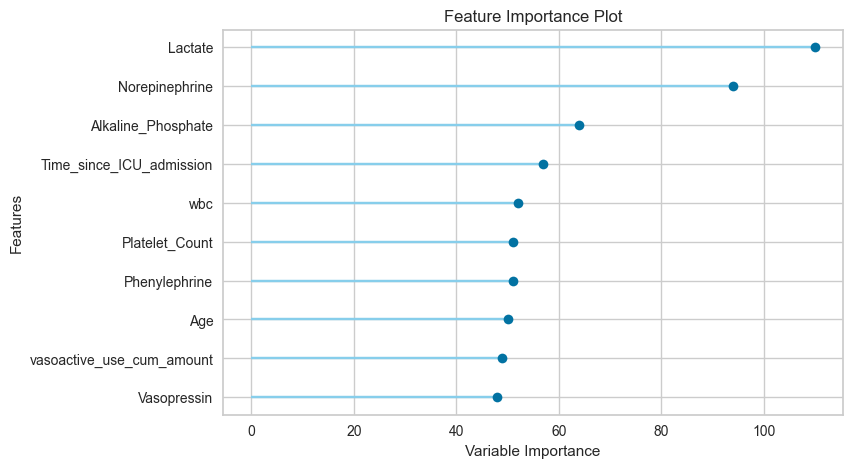

In [71]:
# 피처 공간의 변화와 선형 분리 가능성: supervised contrastive embedding을 통해 같은 클래스의 데이터는 가까워지고, 다른 클래스의 데이터는 멀어지도록 feature 공간을 변형하였는데,
# 이러한 변환은 분류 경계면 형성에 큰 도움을 주어 선형 분리가능성을 높일 수 있었고, 마진 최대화를 통한 최적 결정 경계를 찾는 SVM에 특히 유리했을 것이다.
# 반면, LightGBM과 XGBoost는 결정 트리 기반의 모델로, 변수의 값을 기준으로 분기하는 방식으로 작동한다.
# 이는 contrastive embedding을 통한 feature 변환에 덜 민감하게 반응함을 의미하며, contrastive embedding 변환의 이점을 충분히 활용하지 못할 수 있다.


# 모델의 성능 향상은 단일 feature의 중요도보다는 feature들 간의 상호작용과 전체 feature 집합의 기여도에 더 의존할 수 있음
# 오히려, 이 feature가 결정 경계 형성에 필요한 정보를 제공하고 있으며, 다른 feature들과의 상호작용을 통해 모델의 성능을 향상시킬 수 있음

plot_model(lightgbm, plot = 'feature')

In [62]:
mimic_train_ori_sampling.classes.value_counts().sort_index()

#비율을 만약에 클래스 1보다 줄이면 어떻게 될까?

0    1175656
1      22253
2        380
3      12576
Name: classes, dtype: int64

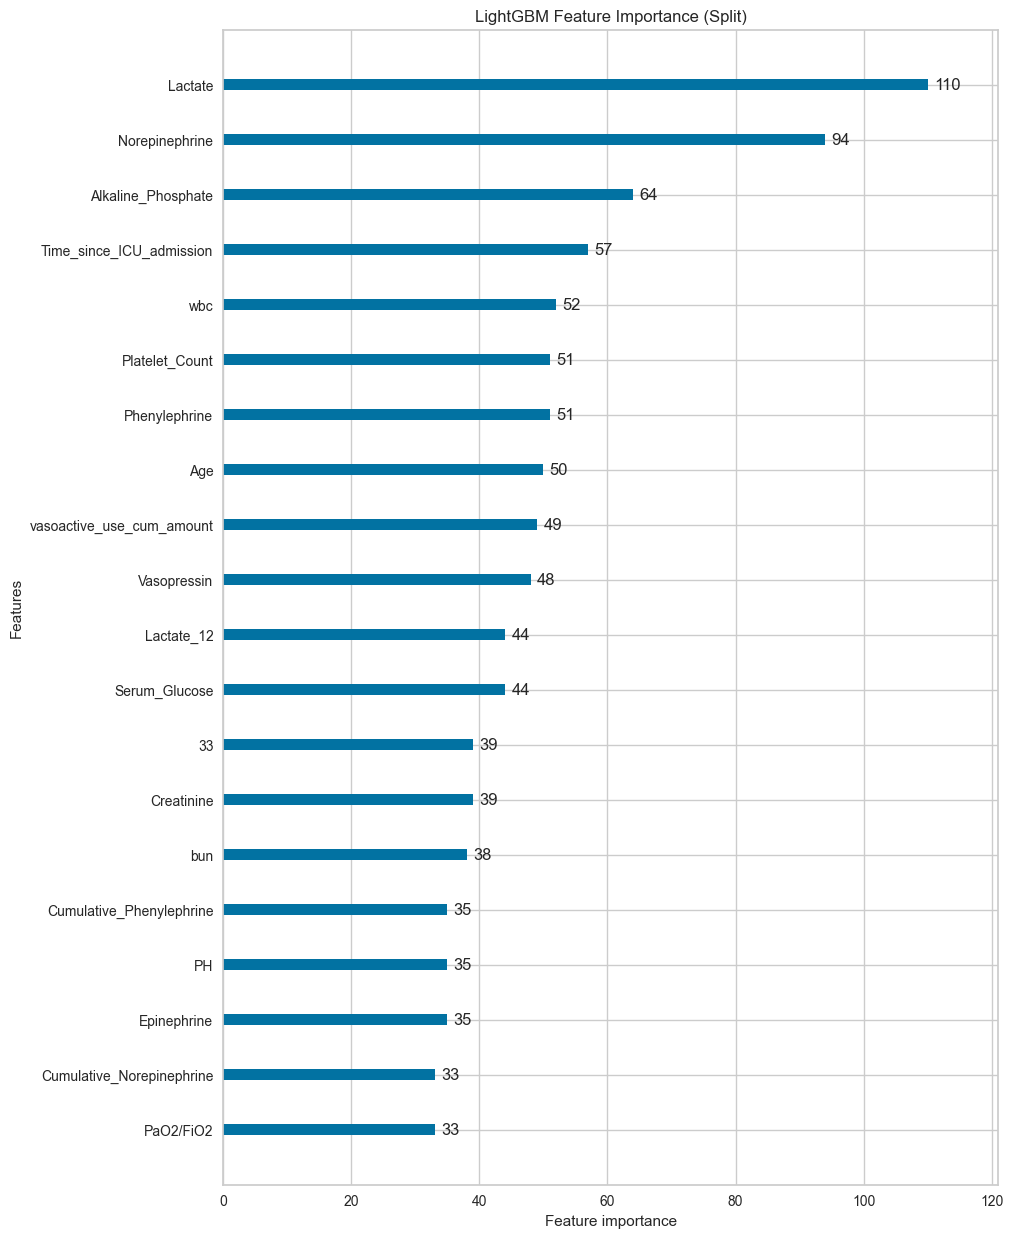

In [72]:
import matplotlib.pyplot as plt
import lightgbm as lgb
lgb.plot_importance(lightgbm, importance_type="split", figsize=(10,15), title="LightGBM Feature Importance (Split)", max_num_features=20)
plt.show()

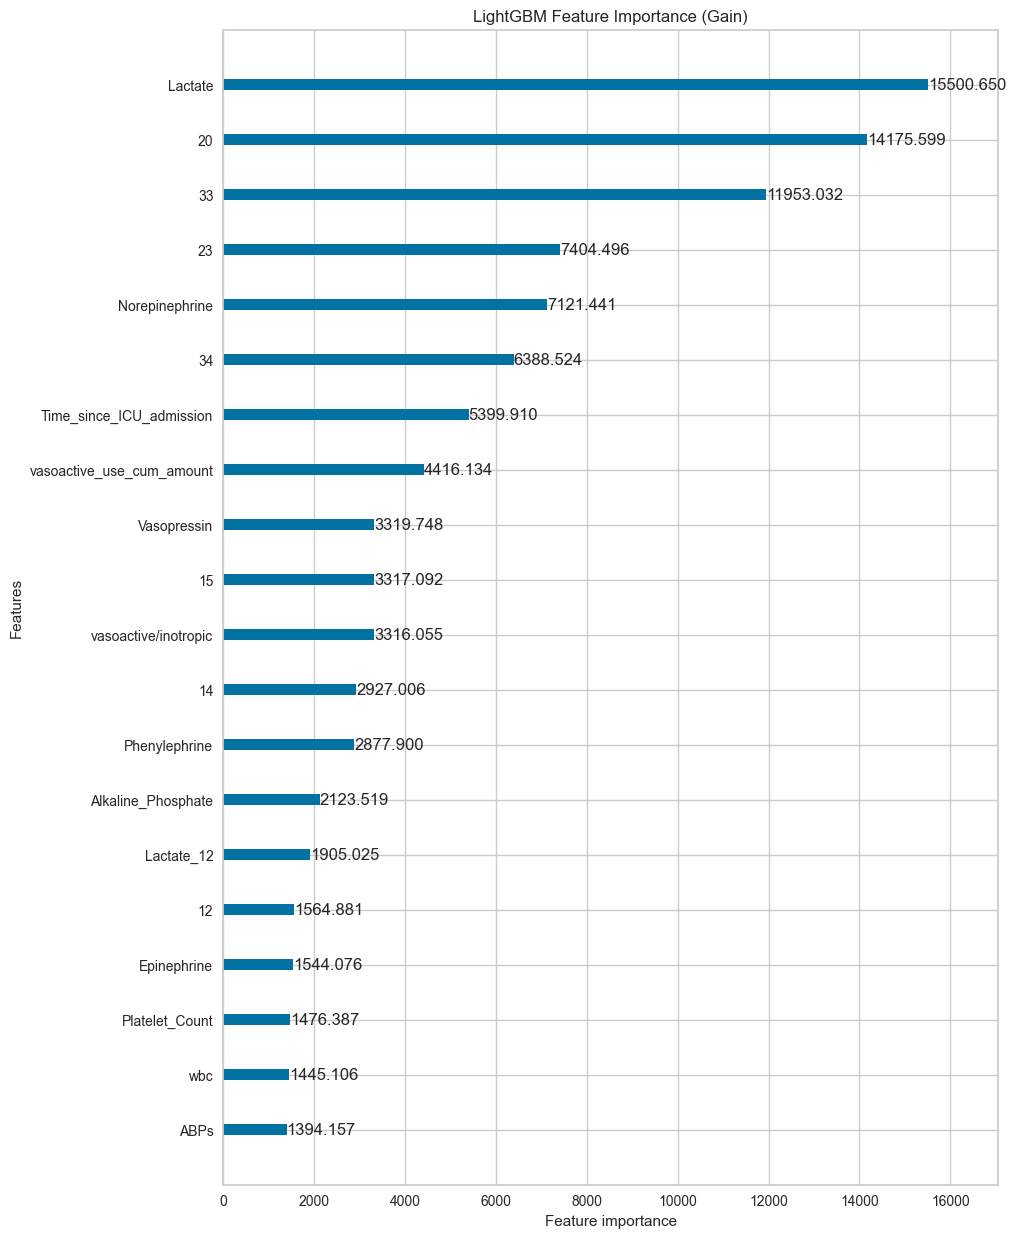

In [73]:
import matplotlib.pyplot as plt
import lightgbm as lgb
lgb.plot_importance(lightgbm, importance_type="gain", figsize=(10,15), title="LightGBM Feature Importance (Gain)", max_num_features=20)
plt.show()

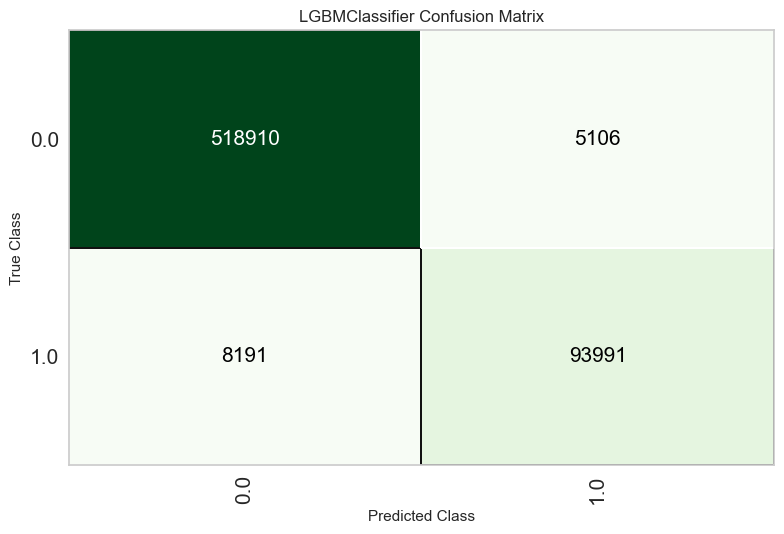

In [65]:
plot_model(lightgbm, plot='confusion_matrix')